# Problem 1

In [2]:
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import math
import sklearn.metrics as metrics

In [3]:
# Load MNIST
f = gzip.open('data/mnist.pkl.gz') 
mnist = pickle.load(f, encoding='latin1')

In [4]:
mnist_train_features = mnist[0][0] #(50000,784)
mnist_train_labels = mnist[0][1]   #(50000,1)

mnist_valid_features = mnist[1][0] #(10000,784)
mnist_valid_labels = mnist[1][1]   #(50000,1)

mnist_test_features = mnist[2][0]  #(10000,784)
mnist_test_labels = mnist[2][1]    #(50000,1)

In [9]:
# Reduce the dataset size for testing, if needed (ex: X_train = mnist_train_features[0:10000])
X_train = mnist_train_features[0:50000]
y_train = mnist_train_labels[0:50000]

X_valid = mnist_valid_features[0:10000]
y_valid = mnist_valid_labels[0:10000]

X_test = mnist_test_features[0:300]
y_test = mnist_test_labels[0:300]

## Building the Model

In [59]:
class NN(object):
    
    def __init__(self,hidden_dims=(1024,2048),weight_mode=None, mode="ReLU"):
        self.b1 = np.zeros((hidden_dims[0]))
        self.b2 = np.zeros((hidden_dims[1]))
        self.b3 = np.zeros((10))
        self.learning_rate = 0.0005
        self.initialize_weights(hidden_dims,weight_mode)
        self.grads = 0
        self.act_mode = mode

    def initialize_weights(self,hidden_dims,weight_mode):
        W1_dim = (784, hidden_dims[0])
        W2_dim = (hidden_dims[0], hidden_dims[1])
        W3_dim = (hidden_dims[1], 10)
        
        if weight_mode == "zero":
            self.W1 = np.zeros(W1_dim)
            self.W2 = np.zeros(W2_dim)
            self.W3 = np.zeros(W3_dim)
            
        elif weight_mode == "normal":
            np.random.seed(23)
            self.W1 = np.random.standard_normal(W1_dim)
            self.W2 = np.random.standard_normal(W2_dim)
            self.W3 = np.random.standard_normal(W3_dim)
            
        elif weight_mode == "glorot":
            np.random.seed(23)
            
            d1 = math.sqrt(6.0 / (W1_dim[0] + W1_dim[1]))
            d2 = math.sqrt(6.0 / (W2_dim[0] + W2_dim[1]))
            d3 = math.sqrt(6.0 / (W3_dim[0] + W3_dim[1]))
            
            self.W1 = np.random.uniform(-d1, d1, W1_dim)
            self.W2 = np.random.uniform(-d2, d2, W2_dim)
            self.W3 = np.random.uniform(-d3, d3, W3_dim)
        
        else:
            raise Exception("Unsupported weight_mode value")

    def forward(self,data):
        cache = {}
        
        cache["h0"] = np.copy(data)
        cache["a1"] = np.dot(cache["h0"], self.W1) + self.b1
        cache["h1"] = self.activation(cache["a1"], self.act_mode)
        cache["a2"] = np.dot(cache["h1"], self.W2) + self.b2
        cache["h2"] = self.activation(cache["a2"], self.act_mode)
        cache["a3"] = np.dot(cache["h2"], self.W3) + self.b3
        cache["h3"] = self.softmax(cache["a3"])
        
        return cache

    def activation(self,data, mode="ReLU"):
        if(mode == "ReLU"):
            return self.ReLU(data)
        elif(mode == "sigmoid"):
            return self.sigmoid(data)
        else:
            raise Exception("Not an activation function")
    
    def activation_derivative(self,data, mode="ReLU"): # RELU derivative
        if(mode == "ReLU"):
            return self.ReLU_derivative(data)
        elif(mode == "sigmoid"):
            return self.sigmoid_derivative(data)
        else:
            raise Exception("Not an activation function")
    
    def sigmoid(self, data):
        return 1/(1+np.exp(-data))
    
    def sigmoid_derivative(self,data):
        return self.sigmoid(data)*(1-self.sigmoid(data))
    
    def ReLU(self,data): # RELU
        return np.where(data > 0, data, 0.0)
    
    def ReLU_derivative(self,data):
        return np.where(data > 0, 1.0, 0.0)

    def loss(self, data, labels, eps = 1e-15): # Cross Entropy loss
        cache = self.forward(data)
        preds = np.clip(cache["h3"], eps, 1 - eps)
        preds = preds / np.sum(preds, axis=1)[:, np.newaxis]
        one_hot_truth = np.eye(10)[labels]
        log_loss = -np.diag(np.matmul(one_hot_truth,np.log(preds).T))
        return  np.average(log_loss)
#         return metrics.log_loss(labels, preds)

    def softmax(self,data): # Numerically stable softmax
        result = np.exp(data - np.max(data, axis=1, keepdims=True))
        result = result / np.sum(result, axis=1, keepdims=True)
        return result

    def backward(self,cache,labels):
        grads = {}

        grads["a3"] = cache["h3"] - np.eye(10)[labels]
        grads["W3"] = np.dot(cache["h2"].T, grads["a3"])
        grads["b3"] = np.sum(grads["a3"], axis=0)
        
        grads["h2"] = np.dot(grads["a3"], self.W3.T)
        grads["a2"] = grads["h2"] * self.activation_derivative(cache["a2"], self.act_mode)
        grads["W2"] = np.dot(cache["h1"].T, grads["a2"])
        grads["b2"] = np.sum(grads["a2"], axis=0)
        
        grads["h1"] = np.dot(grads["a2"], self.W2.T)
        grads["a1"] = grads["h1"] * self.activation_derivative(cache["a1"], self.act_mode)
        grads["W1"] = np.dot(cache["h0"].T, grads["a1"])
        grads["b1"] = np.sum(grads["a1"], axis=0)
        
        self.grads = grads
        
        return grads

    def update(self,grads):
        self.b3 -= (self.learning_rate * grads["b3"])
        self.W3 -= (self.learning_rate * grads["W3"])
        self.b2 -= (self.learning_rate * grads["b2"])
        self.W2 -= (self.learning_rate * grads["W2"])
        self.b1 -= (self.learning_rate * grads["b1"])
        self.W1 -= (self.learning_rate * grads["W1"])

    def train(self, train_data, train_labels, valid_data, valid_labels, mini_batch_size = 0, epochs = 10, learning_rate = 0.0005, lr_decay = 1, lr_decay_intervals = 0):
        self.learning_rate = learning_rate
        train_info = {}
        train_info["train_loss"] = []
        train_info["train_accuracy"] = []
        train_info["valid_loss"] = []
        train_info["valid_accuracy"] = []
        decay_flag = True
        
        # print("Epoch\tAccuracy\tAverage Loss")
        data_mini = []
        label_mini = []
        
        if (mini_batch_size==0):
            mini_batch_size = np.shape(train_data)[0]
            
        if (lr_decay==1):
            decay_flag = False
            
        if (lr_decay>1):
            raise ValueError("lr_decay has to be equal or under to 1")
            
        if (decay_flag==True):
            if lr_decay_intervals!=0:
                lr_decay_intervals = lr_decay_intervals
            else:
                lr_decay_intervals = [0.2,0.6]
        
        for epoch in range(epochs): # TODO: implement mini-batch gradient descent
            for i in range(0, np.shape(train_data)[0], mini_batch_size):
                
                #Mini-batch training
                data_mini = train_data[i:i + mini_batch_size]
                labels_mini = train_labels[i:i + mini_batch_size]
                
                #forward and backward propagation
                cache = self.forward(data_mini)
                grads = self.backward(cache,labels_mini)
                self.update(grads)
                
            #Measuring loss and accuracy
            predictions = np.argmax(cache["h3"], axis=1)
            train_accuracy = np.mean(predictions == labels_mini)
            train_loss = self.loss(data_mini, labels_mini)
            
            valid_cache = self.forward(valid_data)
            valid_pred = np.argmax(valid_cache["h3"], axis=1)
            valid_accuracy = np.mean(valid_pred == valid_labels)
            valid_loss = self.loss(valid_data, valid_labels)
            
            if(decay_flag):
                if (epoch in np.dot(lr_decay_intervals,epochs)):
                    learning_rate = learning_rate * lr_decay
                    print(learning_rate)
            
            train_info["train_loss"].append(train_loss)
            train_info["train_accuracy"].append(train_accuracy)   
            train_info["valid_loss"].append(valid_loss)
            train_info["valid_accuracy"].append(valid_accuracy)
            print("Training epoch ", epoch + 1, "\t", "{0:.4f}".format(train_accuracy), "\t", "{0:.4f}".format(train_loss))
            print("Validation ", "\t", "{0:.4f}".format(valid_accuracy), "\t", "{0:.4f}".format(valid_loss), '\n')
        
        return train_info

    def test(self, data, labels):
        cache = self.forward(data)
        predictions = cache["h3"].argmax(1).astype(int)
        accuracy = np.mean(predictions == labels)
        return accuracy


## Initialization

zero
1 	 0.1700 	 2.2978
2 	 0.1700 	 2.2972
0.0005
3 	 0.1700 	 2.2972
4 	 0.1700 	 2.2972
5 	 0.1700 	 2.2972
6 	 0.1700 	 2.2972
0.00025
7 	 0.1700 	 2.2972
8 	 0.1700 	 2.2972
9 	 0.1700 	 2.2972
10 	 0.1700 	 2.2972

normal


C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in multiply
C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in greater


1 	 0.1700 	 2.2905
2 	 0.1700 	 2.2951
0.0005
3 	 0.1700 	 2.2967
4 	 0.1700 	 2.2971
5 	 0.1700 	 2.2971
6 	 0.1700 	 2.2972
0.00025
7 	 0.1700 	 2.2972
8 	 0.1700 	 2.2972
9 	 0.1700 	 2.2972
10 	 0.1700 	 2.2972

glorot
1 	 0.9100 	 0.2143
2 	 0.9600 	 0.1354
0.0005
3 	 0.9600 	 0.0950
4 	 0.9600 	 0.0709
5 	 0.9700 	 0.0554
6 	 0.9800 	 0.0450
0.00025
7 	 0.9900 	 0.0375
8 	 0.9900 	 0.0320
9 	 1.0000 	 0.0277
10 	 1.0000 	 0.0242



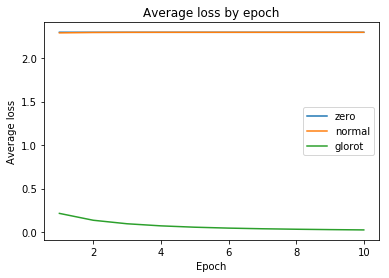

In [7]:
for weight_mode in ["zero", "normal", "glorot"]:
#for weight_mode in ["glorot"]:
    print(weight_mode)
    nn = NN(hidden_dims=(800,300),weight_mode=weight_mode, mode="ReLU")
    train_info = nn.train(X_train, y_train, epochs = 10, mini_batch_size=100, learning_rate = 0.001, lr_decay = 0.5)
    plt.plot(np.arange(1,11,1), train_info["average_losses"], label=weight_mode)
    print()

plt.title("Average loss by epoch")
plt.xlabel("Epoch")
plt.ylabel("Average loss")
plt.legend()
plt.show()

## Hyperparameter Search

In [10]:
# Grid Search

lr = [0.0085, 0.008, 0.0075]
hiddens_dims = [(625,625)]
mini_batch = [64]
epoch = (20,18,22)


# Mode = ReLU
best = 0
best_params = {}

for lr_ in lr:
    for hd in hiddens_dims:
        for mb in mini_batch:
            for epoch_ in epoch:
                #print("Lr : {}, hd : {}, mb : {}".format(lr_, hd, mb))
                model = NN(hidden_dims = hd, weight_mode = "glorot", mode = "ReLU")
                train_log = model.train(X_train, y_train, X_valid, y_valid, epochs = epoch_,
                                        mini_batch_size=mb, learning_rate = lr_, lr_decay = 0.8,
                                        lr_decay_intervals = [0.2, 0.5, 0.8])
                acc = model.test(X_valid, y_valid)
                if(acc>best):
                    best = acc
                    best_params["lr"] = lr_
                    best_params["hd"] = hd
                    best_params["mb"] = mb
                    best_params["epoch"]=epoch_
                              
print(best, best_params)

# # Mode = sigmoid
# best_s = 0
# best_params_s = {}

# for lr_ in lr:
#     for hd in hiddens_dims:
#         for mb in mini_batch:
#             for epoch_ in epoch:
#                 #print("Lr : {}, hd : {}, mb : {}".format(lr_, hd, mb))
#                 model = NN(hidden_dims = hd, weight_mode = "glorot", mode = "sigmoid")
#                 train_log = model.train(X_train, y_train, epochs = epoch_, mini_batch_size=mb, learning_rate = lr_)
#                 acc = model.test(X_valid, y_valid)
#                 if(acc>best_s):
#                     best_s = acc
#                     best_params_s["lr"] = lr_
#                     best_params_s["hd"] = hd
#                     best_params_s["mb"] = mb
#                     best_params_s["epoch"]=epoch_
                              
# print(best_s, best_params_s)

1 	 0.8750 	 0.0321
2 	 0.9375 	 0.0047
3 	 0.9375 	 0.0020
4 	 1.0000 	 0.0040
0.0068000000000000005
5 	 1.0000 	 0.0038
6 	 1.0000 	 0.0027
7 	 1.0000 	 0.0016
8 	 1.0000 	 0.0008
9 	 1.0000 	 0.0017
10 	 1.0000 	 0.0016
0.00544
11 	 1.0000 	 0.0021
12 	 1.0000 	 0.0002
13 	 1.0000 	 0.0008
14 	 1.0000 	 0.0006
15 	 1.0000 	 0.0002
16 	 1.0000 	 0.0005
0.004352000000000001
17 	 1.0000 	 0.0005
18 	 1.0000 	 0.0001
19 	 1.0000 	 0.0000
20 	 1.0000 	 0.0000
1 	 0.8750 	 0.0321
2 	 0.9375 	 0.0047
3 	 0.9375 	 0.0020
4 	 1.0000 	 0.0040
5 	 1.0000 	 0.0038
6 	 1.0000 	 0.0027
7 	 1.0000 	 0.0016
8 	 1.0000 	 0.0008
9 	 1.0000 	 0.0017
0.0068000000000000005
10 	 1.0000 	 0.0016
11 	 1.0000 	 0.0021
12 	 1.0000 	 0.0002
13 	 1.0000 	 0.0008
14 	 1.0000 	 0.0006
15 	 1.0000 	 0.0002
16 	 1.0000 	 0.0005
17 	 1.0000 	 0.0005
18 	 1.0000 	 0.0001
1 	 0.8750 	 0.0321
2 	 0.9375 	 0.0047
3 	 0.9375 	 0.0020
4 	 1.0000 	 0.0040
5 	 1.0000 	 0.0038
6 	 1.0000 	 0.0027
7 	 1.0000 	 0.0016
8 	 1.0

96.3% lr = 0.008, hd = 625,625, mb = 64, epoch = 40

96.8% lr = 0.008, hd = 625,625, mb = 64, epoch = 20

98.5% lr = 0.0075, hd = 625, 625, mb = 64, epoch = 22

## Validating Gradients Using Finite Difference

In [ ]:
# Code taken from Marc-André's homework#3 of IFT6390 class.
lr = 0.0075
hd = (625,625)
mb = 64
epoch = 10
eps = (1/10, 1/50, 1/100, 1/500, 1/1000)

model_finite_diff = NN(hidden_dims=hd, weight_mode="glorot", mode="ReLU")
log = model_finite_diff.train(X_train, y_train, X_valid, y_valid, epochs = epoch,
                                        mini_batch_size=mb, learning_rate = lr, lr_decay = 0.8,
                                        lr_decay_intervals = [0.2, 0.5, 0.8])


In [56]:
def finite_diff_gradient_check(model, sample_X, sample_Y, weights_idx = 10, eps = (1/100)):
    """
    -----
    Parameters: 
        model: neural net with initialized weights
        weights_idx: first weights to evaluate theta = 1:weights_idx
        eps: epsilon values to try for finite difference
        sample_X : data point
        sample_Y : data point label
    """
    for i in range(weights_idx):
        for eps_ in eps:
            print(eps_)
            model.W1[0,i] += eps_
            print(model.W1[0,i])
            loss_eps_plus = model.loss(sample_X, sample_Y)
            print(loss_eps_plus)
            model.W1[0,i] -= 2*eps_
            print(model.W1[0,i])
            loss_eps_minus = model.loss(sample_X, sample_Y)
            model.W1[0,i] += eps_
            print(loss_eps_minus)
            finite_diff = (loss_eps_plus - loss_eps_minus)/(2*eps_)
            print("Finite Gradient : ",finite_diff)
            print("Backprop gradient : ", model.grads["W1"][0,i])
            print("Ratio : ", finite_diff / model.grads["W1"][0,i])
            print("-----------------------------------", '\n')

            

finite_diff_gradient_check(model_finite_diff, (X_train[0, np.newaxis]), y_train[0], eps=eps)



0.1
-0.562742420250302
0.0006869081364070681
-0.7627424202503019
0.0006869081364070681
Finite Gradient :  0.0
Backprop gradient :  0.0
Ratio :  nan
----------------------------------- 

0.02
-0.7427424202503019
0.0006869081364070681
-0.7827424202503019
0.0006869081364070681
Finite Gradient :  0.0
Backprop gradient :  0.0
Ratio :  nan
----------------------------------- 

0.01
-0.7727424202503019
0.0006869081364070681
-0.792742420250302
0.0006869081364070681
Finite Gradient :  0.0
Backprop gradient :  0.0
Ratio :  nan
----------------------------------- 

0.002
-0.790742420250302
0.0006869081364070681
-0.794742420250302
0.0006869081364070681
Finite Gradient :  0.0
Backprop gradient :  0.0
Ratio :  nan
----------------------------------- 

0.001
-0.793742420250302
0.0006869081364070681
-0.795742420250302
0.0006869081364070681
Finite Gradient :  0.0
Backprop gradient :  0.0
Ratio :  nan
----------------------------------- 

0.1
-0.5066660597218868
0.0006869081364070681
-0.7066660597218868

C:\Users\JP\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
onehot_Y = to_categorical(Y, num_classes=self.m).reshape((1, self.m))
self.bprop(X,onehot_Y)

loss_fprop = self.loss

eta = 10**(-5)

finite_grad_W1 = self.check_onebyone(X, Y, eta, loss_fprop, self.W1, (self.dh, self.d))
ratio_W1 = np.nanmean(finite_grad_W1/self.grad_W1)

finite_grad_W2 = self.check_onebyone(X, Y, eta, loss_fprop, self.W2, (self.m, self.dh))
ratio_W2 = np.nanmean(finite_grad_W2/self.grad_W2)

finite_grad_b1 = self.check_onebyone(X, Y, eta, loss_fprop, self.b1, (1, self.dh))
ratio_b1 = np.nanmean(finite_grad_b1/self.grad_b1.reshape((1, self.dh)))

finite_grad_b2 = self.check_onebyone(X, Y, eta, loss_fprop, self.b2, (1, self.m))
ratio_b2 = np.nanmean(finite_grad_b2/self.grad_b2.reshape((1, self.m)))

check = True
ratios = [ratio_W1 ,ratio_W2, ratio_b1, ratio_b2]

for ratio in ratios:
    check = check and ratio < 1.01 and ratio > 0.99

if (verbose):
    print("Backprop gradient W1")
    print(np.nan_to_num(self.grad_W1))
    print("Finite gradient W1")
    print(np.nan_to_num(finite_grad_W1))
    print("     -------------------------------")
    print("Backprop gradient b1")
    print(np.nan_to_num(self.grad_b1))
    print("Finite gradient b1")
    print(np.nan_to_num(finite_grad_b1))
    print("     -------------------------------")
    print("Backprop gradient W2")
    print(np.nan_to_num(self.grad_W2))
    print("Finite gradient W2")
    print(np.nan_to_num(finite_grad_W2))
    print("     -------------------------------")
    print("Backprop gradient b2")
    print(np.nan_to_num(self.grad_b2))
    print("Finite gradient b2")
    print(np.nan_to_num(finite_grad_b2))
    print("     -------------------------------")
    print(f" ratio W1 : {ratio_W1}  \n ratio b1 : {ratio_b1} \
          \n ratio W2 : {ratio_W2} \n ratio b2 : {ratio_b2}")

return check